# Imports

In [1]:
from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt
from batch.label_transforms.ahmet_refine_label_boundary import P_refine_label_boundary
from batch.data_transforms.ahmet_db_with_limits import db_with_limits, xr_db_with_limits
import seaborn as sns
from imblearn.under_sampling import NearMiss

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = 'C:/users/apa055/Desktop/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y
survey = readers[0]

# Selecting Data Portion

C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))


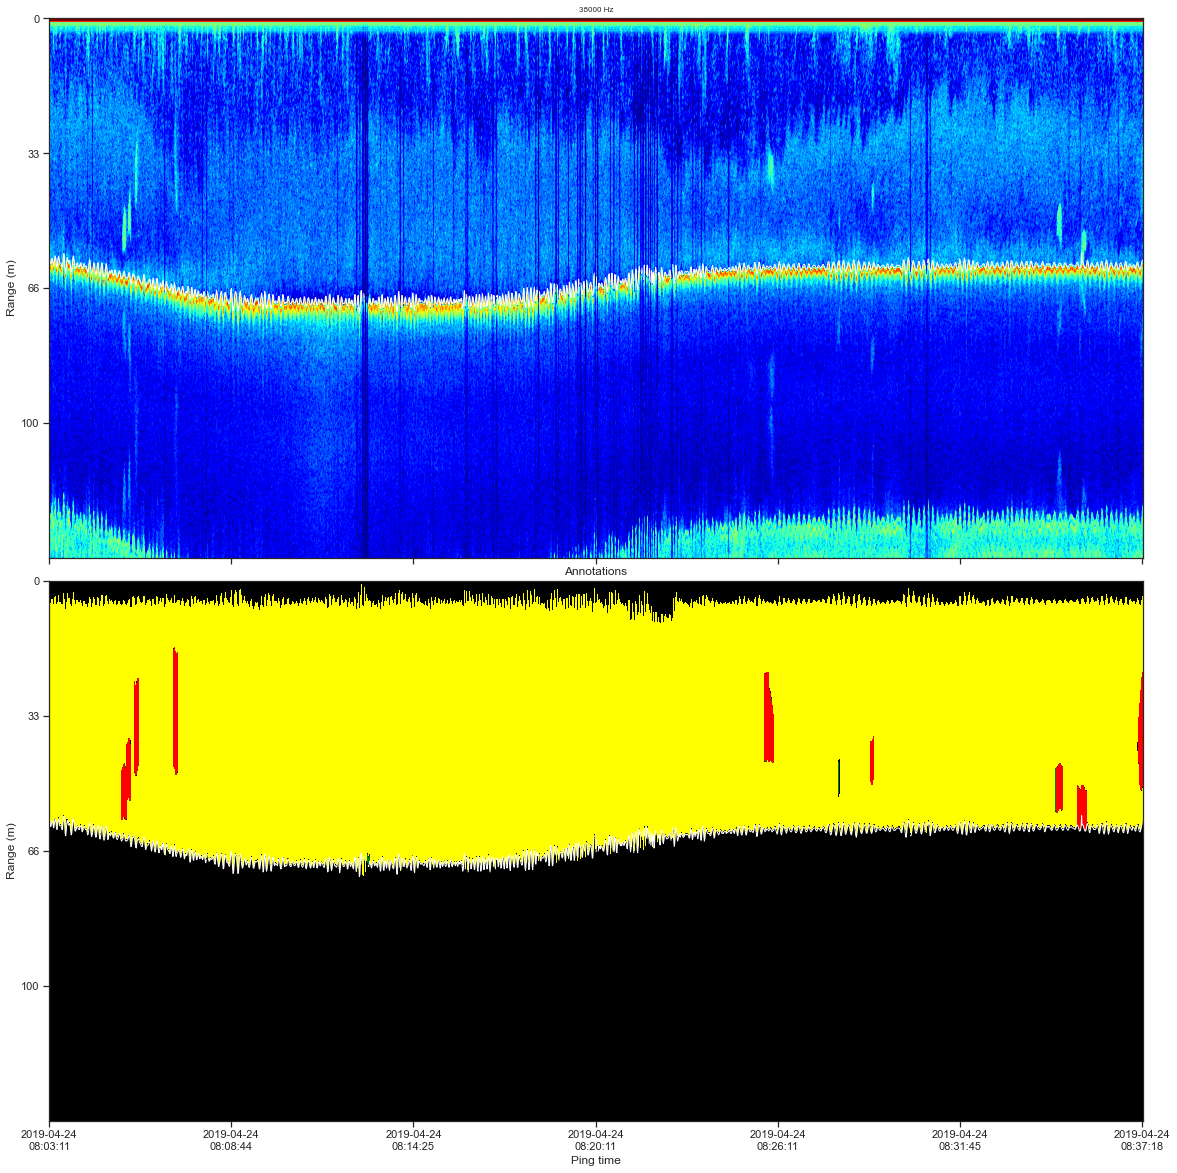

In [179]:
idx_ping = 46776 #55000 TODO: Configure for the Possible Sandeel
n_pings = 2000 #6000 Possandeel in oldugu yer, bu kismi tekrar analiz et
idx_range = 0
n_range = 700

# selected echogram: ping_time = (46776:47276), range = (0:500) (500*500 = 250000 pixels * 4 frequency + 1 depth channel)

survey.visualize(ping_idx=idx_ping, n_pings=n_pings, range_idx=idx_range,
                 n_range=n_range, draw_seabed=True, show_labels=True, frequencies=[38000])

# Creating Data and Labels Arrays

In [180]:
# to get data slice
org_sv = survey.get_data_slice(idx_ping=idx_ping, n_pings=n_pings, idx_range=idx_range, n_range=n_range,
                                   return_numpy=False, frequencies=[18000, 38000, 120000, 200000])
data_Sv = xr_db_with_limits(org_sv)

# to get label slice
y_label = survey.get_label_slice(idx_ping=idx_ping, n_pings=n_pings, idx_range=idx_range, n_range=n_range,
                                 return_numpy=True)
# Update -1 Class
y_label[y_label==-1] = 0

# Annotation Modification
collection = P_refine_label_boundary(ignore_zero_inside_bbox=False, threshold_val=[1e-07, 1e-04],
                                       frequencies=[18, 38, 120, 200])(
    data=org_sv.values, labels=y_label,echogram=org_sv.values)

# Defining Sv data for 4 frequency channels and modified labels as numpy arrays
Sv_data, mod_labels = db_with_limits(collection[0]), collection[1]

C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))


# Summary of the Labels

In [295]:
print(np.unique(mod_labels, return_counts=True))
100*np.unique(mod_labels, return_counts=True)[1] / np.unique(mod_labels, return_counts=True)[1].sum()

(array([ 0.,  1., 27.], dtype=float32), array([1395498,      91,    4411], dtype=int64))


array([99.67842857,  0.0065    ,  0.31507143])

# Creating Pandas Dataframe Containing Sv Data, Depth and Labels

In [182]:
# Creating flattened Numpy Array with frequency and depth
data_list = [Sv_data[i].flatten() for i in range(4)]
input_data_flat = np.asarray(data_list).T

# Converting into Pandas Dataframe
pd_all = pd.DataFrame(input_data_flat, columns=('18_Sv', '38_Sv', '120_Sv', '200_Sv'))
pd_all['label'] = mod_labels.flatten()
# Change labels column to 'object' datatype
pd_all.label = pd_all.label.astype('object')

# Visualization of each input pair

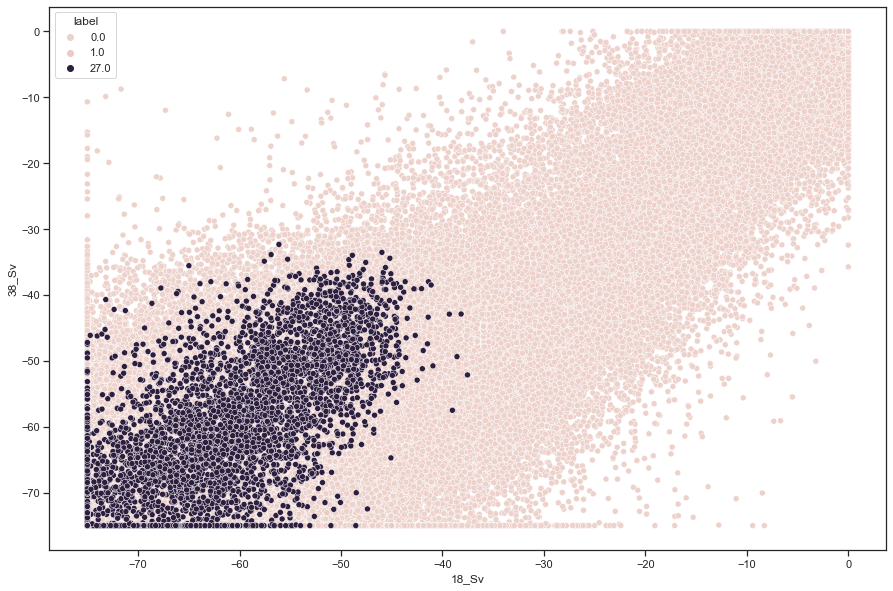

In [183]:
# Sandeel on top of Background
plt.figure(figsize=(15,10))
hue_order = ["27.0", "1.0", "0.0"]
sns.scatterplot(data=pd_all.sort_values(by='label'), x="18_Sv", y="38_Sv", hue='label', hue_order=hue_order)
plt.show()

# Near Miss Algorithm

In [184]:
%%time
# 2000/0.025= 80000 samples of pixels, SD + Bg
nr = NearMiss(version=2, sampling_strategy={'0.0':len(mod_labels[mod_labels==27])})
#!!!! Nan Values should be filled if there is Nan
#pd_all.fillna(0, inplace=True)


X_train, y_train = pd_all.iloc[:,0:4], pd_all.iloc[:,4]
X_near, Y_near= nr.fit_resample(X_train, y_train.ravel().astype('str'))

Wall time: 8.36 s


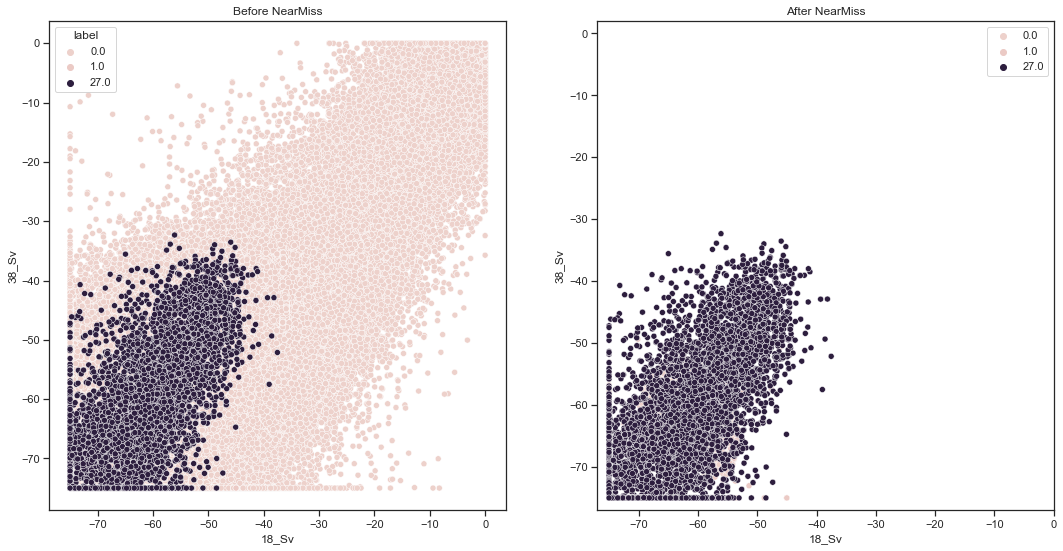

In [185]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(18,9))
sns.scatterplot(data=pd_all.sort_values(by='label'), x="18_Sv", y="38_Sv",
                hue='label', ax=axes[0]).set(title='Before NearMiss')
sns.scatterplot(data=X_near, x="18_Sv", y="38_Sv", hue=Y_near.astype('float'),
                ax=axes[1]).set(title='After NearMiss')
plt.xlim(left=-77, right=0)
plt.ylim(-77, 2)
plt.show()

# Total samples by NearMiss Algorithm

In [186]:
np.unique(Y_near, return_counts=True)

(array(['0.0', '1.0', '27.0'], dtype='<U4'),
 array([4411,   91, 4411], dtype=int64))

# Final Data

In [187]:
resulting_data = pd.DataFrame.copy(pd_all)
resulting_data['sampled'] = 0
# Assigning 1 for sampled pixels
for _, i in tqdm(enumerate(nr.sample_indices_), total=len(nr.sample_indices_)):
    resulting_data.iloc[i,5] = 2

100%|██████████| 8913/8913 [01:39<00:00, 89.28it/s] 


In [314]:
resulting_data.label.value_counts()

0.0     1395498
27.0       4411
1.0          91
Name: label, dtype: int64

In [189]:
# Creating Final Array

# Resizing sampled column
output = resulting_data['sampled'].values.reshape(n_pings, n_range).astype('float')
final_out=(output+resulting_data['label'].values.reshape(n_pings, n_range).astype('float'))

#Updating the annotation numbers
final_out[final_out==2], final_out[final_out==3], final_out[final_out==29]  = 0.5, 1, 27

# Plot Data Summary (Excluding Bg(0), Selected Bg, Other, Sandeel)

In [190]:
# Proportion of Disabled Bg, Selected Bg, Other, Sandeel, respectively
np.set_printoptions(suppress=True)
aa = np.round_(100*np.unique(final_out, return_counts=True)[1]/(final_out.shape[0]*final_out.shape[1]),2)
print(f'% {aa}')

% [99.36  0.32  0.01  0.32]


In [191]:
np.unique(final_out, return_counts=True)

(array([ 0. ,  0.5,  1. , 27. ]),
 array([1391087,    4411,      91,    4411], dtype=int64))

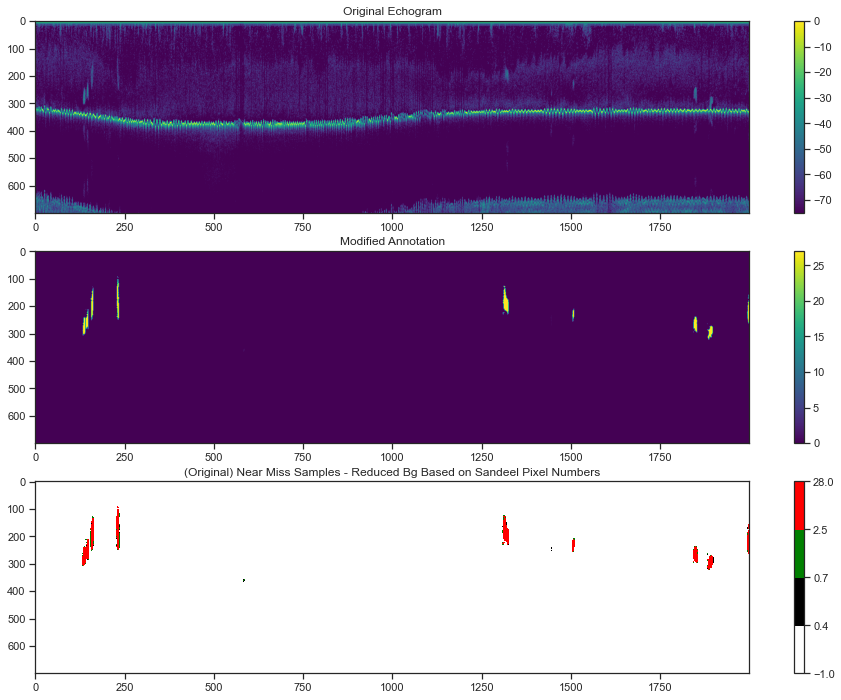

In [192]:
# Visualization of Near Miss Results
import matplotlib.colors as mcolors

cmap_labels = mcolors.ListedColormap(['white', 'black', 'green', 'red']) # green = other, red = sandeel
boundaries_labels = [-1, 0.4, 0.7, 2.5, 28]
norm_labels = mcolors.BoundaryNorm(boundaries_labels, cmap_labels.N, clip=True)

plt.figure(figsize=(16,12))
plt.subplot(3,1,3)
plt.title('(Original) Near Miss Samples - Reduced Bg Based on Sandeel Pixel Numbers')
plt.imshow(final_out.T,
           cmap=cmap_labels, norm=norm_labels, aspect='auto')
plt.colorbar()
plt.subplot(3,1,1)
plt.title('Original Echogram')
plt.imshow(data_Sv.sel(frequency=38000).values.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplot(3,1,2)
plt.title('Modified Annotation')
plt.imshow(mod_labels.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplots_adjust(wspace=0)
plt.autoscale(True)
plt.show()

# Taking Random 500 Samples from Sandeel, Selected Background, and Other

In [284]:
n = 200 # number of pixel coordinates for each class: Sandeel, Other, Selected Background
near_coordinates = np.zeros(shape=(n*3, 3)) # multiplication by 3 is for the total number of classes here
for i, cls in enumerate([0.5, 1, 27]):
    for j in range(n):
        cond = np.argwhere(final_out==cls)
        near_coordinates[(n*i)+j,:2] = cond[np.random.randint(len(cond))]
        near_coordinates[(n*i)+j,2] = cls


# Calculating Statistics for the Corresponding Coordinates

In [285]:
# Updating Exceeding locations
deneme_coord = np.copy(near_coordinates).astype(float)
deneme_coord[deneme_coord[:,0]<patch_size[0]//2,0] = float(patch_size[0]//2)
deneme_coord[deneme_coord[:,0]>org_sv.shape[1]-patch_size[0]//2,0] = org_sv.shape[1]-patch_size[0]//2
deneme_coord[deneme_coord[:,1]<patch_size[0]//2,1]= patch_size[0]//2
deneme_coord[deneme_coord[:,1]>org_sv.shape[2]-patch_size[0]//2,1] = org_sv.shape[2]-patch_size[0]//2
deneme_coord[:,0] = deneme_coord[:,0] + idx_ping
deneme_coord

array([[48247. ,   572. ,     0.5],
       [48363. ,   572. ,     0.5],
       [47825. ,   364. ,     0.5],
       ...,
       [48618. ,   262. ,    27. ],
       [47008. ,   139. ,    27. ],
       [48648. ,   231. ,    27. ]])

In [266]:
# Filtering exceeding patches
# deneme_coord = near_coordinates[(near_coordinates[:,0]>=patch_size[0]//2) &
#                                 (near_coordinates[:,0]<=org_sv.shape[1]-patch_size[0]//2) &
#                                 (near_coordinates[:,1]>=patch_size[0]//2) &
#                                 (near_coordinates[:,1]<=org_sv.shape[2]-patch_size[0]//2)]
# deneme_coord[:,0] = deneme_coord[:,0] + idx_ping
# deneme_coord.shape

(4251, 3)

In [286]:
from utils.ahmet_patch_statistics_extract import GeneratePatchStat
deneme = GeneratePatchStat(readers[0], deneme_coord[:,:2].astype('int'), patch_size=(256,256))
deneme.calculate_stats(only_pixel_counts=False)

  0%|          | 0/600 [00:00<?, ?it/s]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
  0%|          | 1/600 [00:01<11:45,  1.18s/it]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
  0%|          | 2/600 [00:02<11:05,  1.11s/it]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
  0%|          | 3/600 [00:03<10:42,  1.08s/it]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
  1%|          | 4/600 [00:04<10:29,  1.06s/it]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in lon

,x,y,mean_Sv,mode_Sv,std_Sv,0_Sv,25_Sv,50_Sv,75_Sv,95_Sv,...,mean_bg,mode_bg,std_bg,0_bg,25_bg,50_bg,75_bg,95_bg,100_bg,class
0,48247.0,572.0,-70.449646,-75.0,9.807438,-75.0,-75.0,-75.000000,-75.000000,-47.193554,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,seabed
1,48363.0,572.0,-70.482513,-75.0,9.697330,-75.0,-75.0,-75.000000,-75.000000,-47.550431,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,seabed
2,47825.0,364.0,-69.999786,-75.0,11.496276,-75.0,-75.0,-75.000000,-69.420889,-49.441359,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,seabed
3,47221.0,391.0,-68.343353,-75.0,13.101472,-75.0,-75.0,-73.822575,-67.527893,-37.814662,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,seabed
4,48050.0,352.0,-69.790543,-75.0,11.776862,-75.0,-75.0,-75.000000,-69.163382,-49.236185,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,seabed_sandeel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,46923.0,213.0,-70.094398,-75.0,9.125189,-75.0,-75.0,-73.597557,-67.942202,-59.270791,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,seabed_sandeel
596,48648.0,206.0,-68.613853,-75.0,11.431754,-75.0,-75.0,-72.052471,-66.609859,-54.084177,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,seabed_sandeel
597,48618.0,262.0,-68.050285,-75.0,11.964096,-75.0,-75.0,-71.884766,-66.055265,-46.295670,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,seabed_sandeel
598,47008.0,139.0,-71.166733,-75.0,5.903645,-75.0,-75.0,-75.000000,-68.760712,-59.195259,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,sandeel


# Summary Information of the Extracted Patches Using Near Miss

In [287]:
# Patch Class Summaries
print(deneme.stats['class'].value_counts())
print(deneme.stats['class'].value_counts(normalize=True))

seabed_sandeel          150
seabed_sandeel_other    146
seabed_other            114
seabed                   76
sandeel                  54
background               48
sandeel_other            12
Name: class, dtype: int64
seabed_sandeel          0.250000
seabed_sandeel_other    0.243333
seabed_other            0.190000
seabed                  0.126667
sandeel                 0.090000
background              0.080000
sandeel_other           0.020000
Name: class, dtype: float64


In [288]:
# Pixelwise Percentages
ot, sd, bg, sm = deneme.stats.nop_other.sum(), deneme.stats.nop_sandeel.sum(), deneme.stats.nop_background.sum(), (deneme.stats.nop_other.sum()+deneme.stats.nop_sandeel.sum()+deneme.stats.nop_background.sum())
print(f'Other = % {(100*ot/sm):.2f}, Sandeel = % {100*sd/sm:.2f}, Background = % {100*bg/sm:.2f}')

Other = % 0.04, Sandeel = % 1.03, Background = % 98.93


# Example Visualizations

In [289]:
deneme.stats.sort_values('nop_sandeel', ascending=False).head(20)

,x,y,mean_Sv,mode_Sv,std_Sv,0_Sv,25_Sv,50_Sv,75_Sv,95_Sv,...,mean_bg,mode_bg,std_bg,0_bg,25_bg,50_bg,75_bg,95_bg,100_bg,class
423,46934.0,199.0,-71.304588,-75.0,6.226062,-75.0,-75.0,-74.514900,-68.975071,-61.891880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
421,47007.0,180.0,-72.011948,-75.0,4.848752,-75.0,-75.0,-75.000000,-70.069447,-62.911519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sandeel
539,47006.0,204.0,-71.806229,-75.0,5.081674,-75.0,-75.0,-75.000000,-69.654982,-62.732973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
432,47010.0,206.0,-71.766960,-75.0,5.172314,-75.0,-75.0,-75.000000,-69.597294,-62.665045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
550,46933.0,189.0,-71.606789,-75.0,5.111026,-75.0,-75.0,-74.808327,-69.211525,-62.220373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
508,46936.0,196.0,-71.458305,-75.0,5.693377,-75.0,-75.0,-74.646992,-69.095118,-62.117643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
499,46934.0,192.0,-71.562424,-75.0,5.243917,-75.0,-75.0,-74.717991,-69.164740,-62.207409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
552,46937.0,181.0,-71.643990,-75.0,5.042894,-75.0,-75.0,-74.970448,-69.268421,-62.178268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
434,47007.0,194.0,-71.995132,-75.0,4.787818,-75.0,-75.0,-75.000000,-69.985806,-63.096395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
536,46935.0,200.0,-71.258133,-75.0,6.407271,-75.0,-75.0,-74.497574,-68.947985,-61.810416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel


0.5


C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))


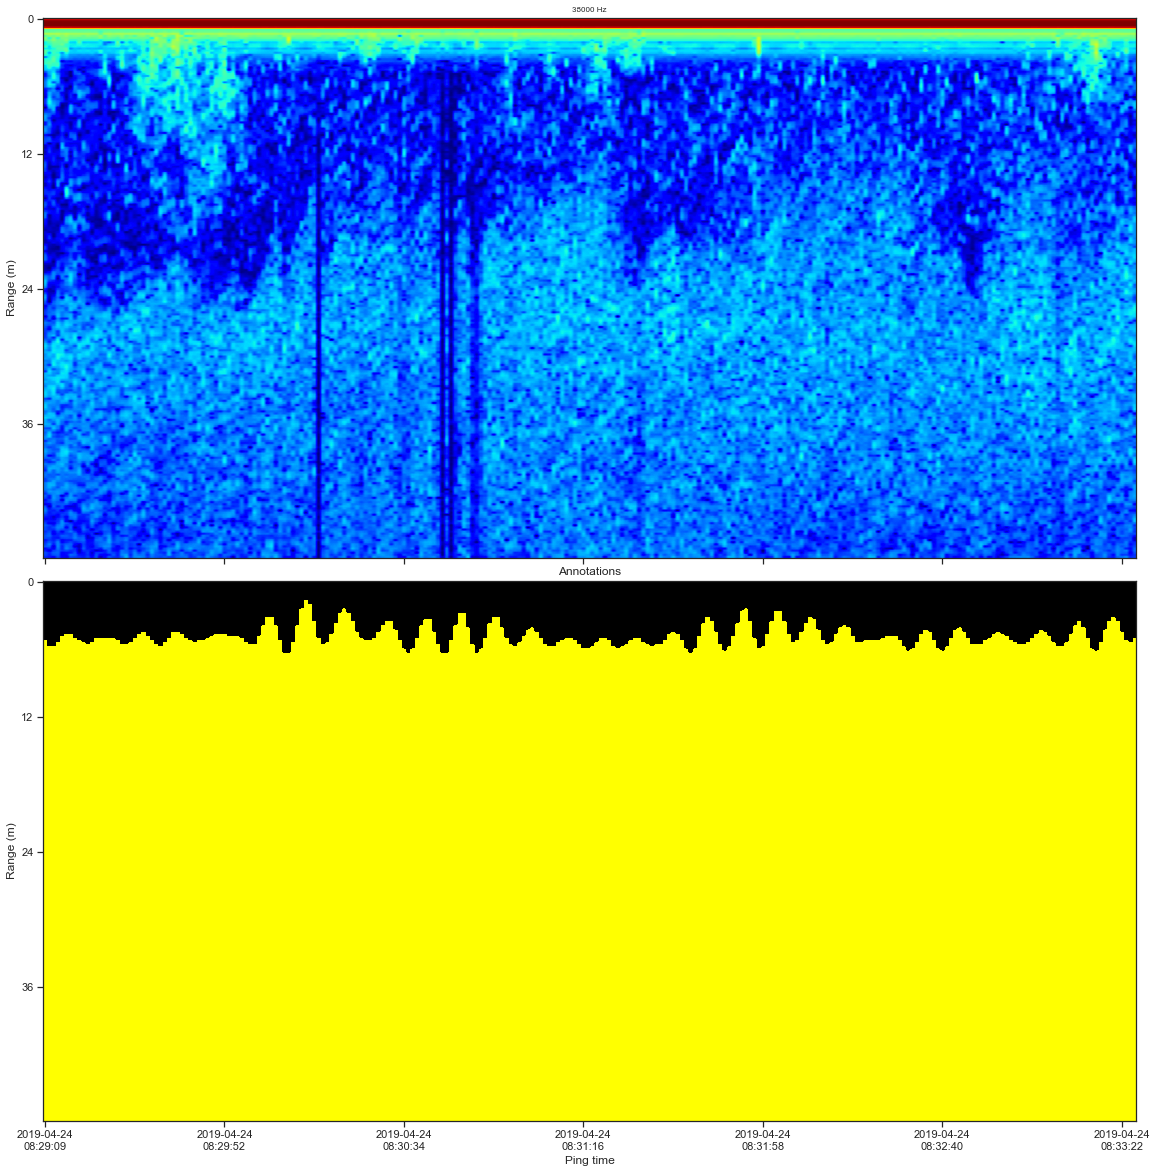

In [313]:
row = 150
ping_idx = int(deneme_coord[row, 0]) - 128
range_idx = int(deneme_coord[row, 1]) - 128
print(deneme_coord[row, 2])
survey.visualize(ping_idx, n_pings=256, range_idx=range_idx, n_range=256, frequencies=[38000])